In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing import image_dataset_from_directory
from google.colab import drive
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os

In [3]:
# Set random seed for reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 100
NUM_CLASSES = 30
DATASET_PATH = "/content/drive/MyDrive/Colab Notebooks/SEMESTER 7/archive"
TRAIN_PATH = "/content/drive/MyDrive/Colab Notebooks/SEMESTER 7/archive/train"
VALID_PATH = "/content/drive/MyDrive/Colab Notebooks/SEMESTER 7/archive/valid"
TEST_PATH = "/content/drive/MyDrive/Colab Notebooks/SEMESTER 7/archive/test"

In [4]:
# Prepare datasets
train_ds = image_dataset_from_directory(
    TRAIN_PATH,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    VALID_PATH,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

test_ds = image_dataset_from_directory(
    TEST_PATH,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 4793 files belonging to 30 classes.
Found 150 files belonging to 30 classes.
Found 150 files belonging to 30 classes.


In [5]:
# Get class names
class_names = train_ds.class_names

In [6]:
# Count data in each class
data_counts = {class_name: len(os.listdir(os.path.join(TRAIN_PATH, class_name))) for class_name in class_names}

<ipython-input-7-dcaa512af642>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(data_counts.keys()), y=list(data_counts.values()), palette='viridis')


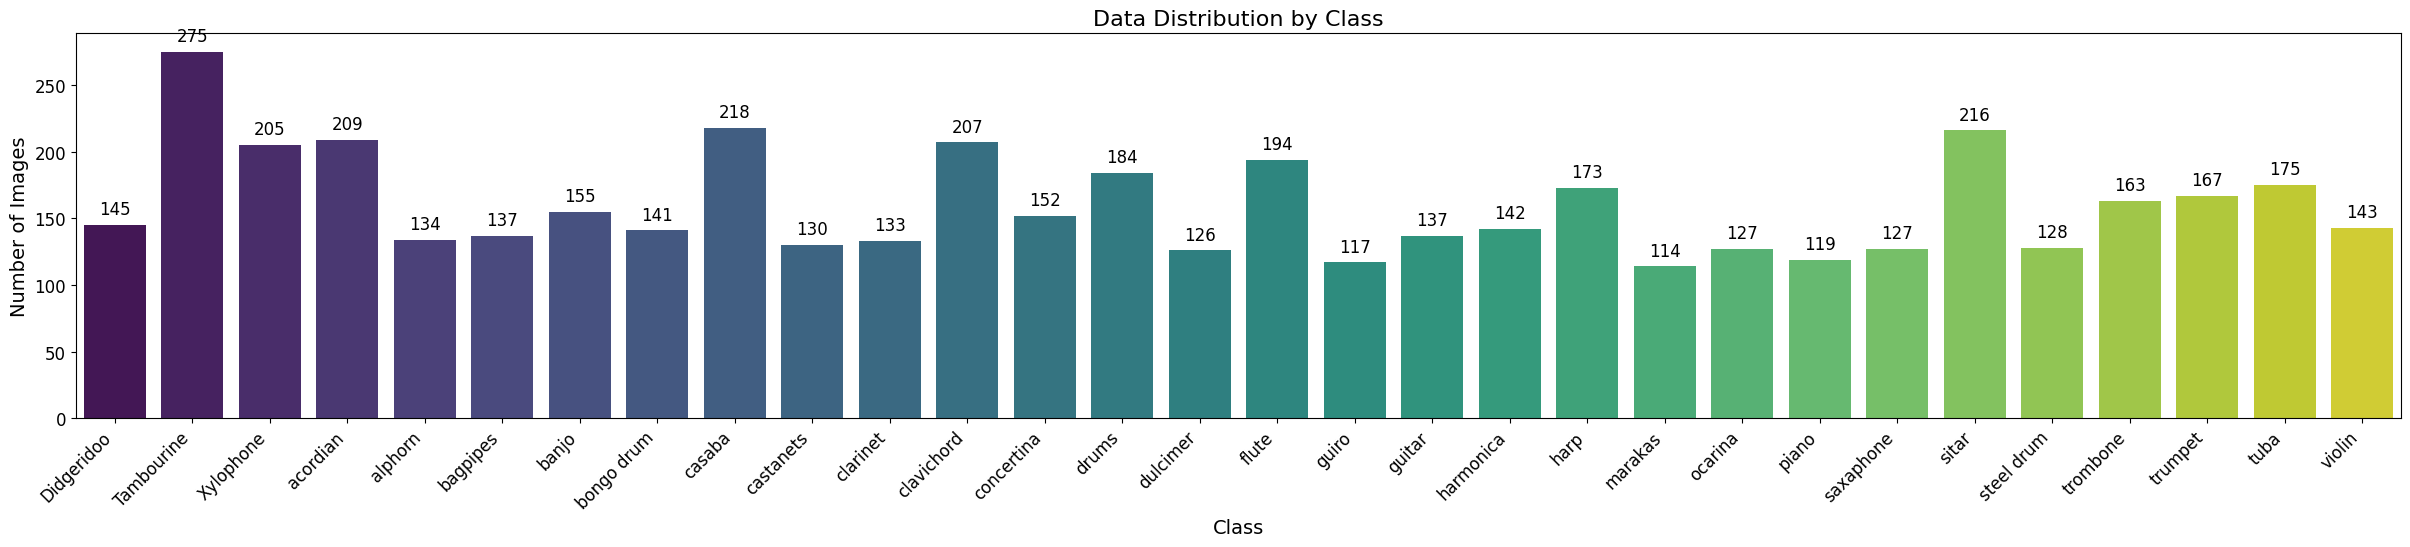

In [7]:
# Visualize data distribution
plt.figure(figsize=(30, 5))
sns.barplot(x=list(data_counts.keys()), y=list(data_counts.values()), palette='viridis')

for i, count in enumerate(data_counts.values()):
    plt.text(i, count + 5, str(count), ha='center', va='bottom', color='black', fontsize=12)

plt.title('Data Distribution by Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)

# Rotate class names for better readability
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12)

plt.show()


In [8]:
from tensorflow.keras import Sequential

# Data augmentation layer
data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", seed=SEED),
    layers.RandomRotation(0.2, seed=SEED),
    layers.RandomZoom(0.2, seed=SEED),
    layers.RandomContrast(0.2, seed=SEED)
])

# Augment the train dataset
augmented_train_ds = train_ds.concatenate(
    train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
).concatenate(
    train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
)

# Ensure the dataset is 2.5x larger
augmented_train_ds = augmented_train_ds.take(len(train_ds) * 5 // 2)

# Verify the size of the augmented dataset
print(f"Original train dataset size: {len(train_ds)} batches")
print(f"Augmented train dataset size: {len(augmented_train_ds)} batches")


Original train dataset size: 150 batches
Augmented train dataset size: 375 batches


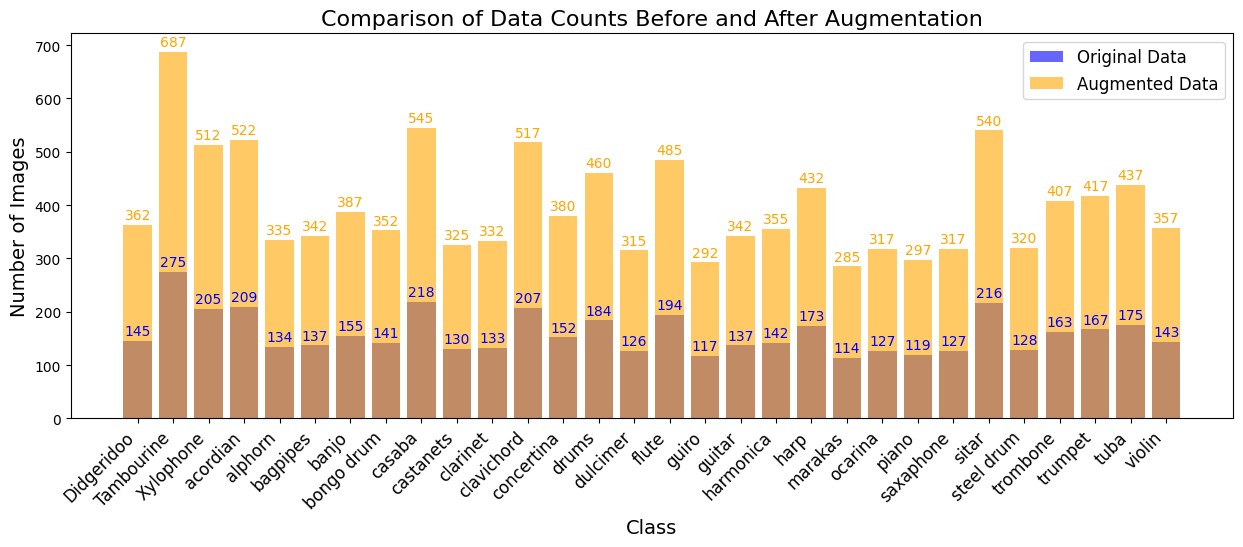

In [9]:
# Calculate original and augmented data counts
original_data_counts = {class_name: len(os.listdir(os.path.join(TRAIN_PATH, class_name))) for class_name in class_names}
augmented_data_counts = {class_name: count * 2.5 for class_name, count in original_data_counts.items()}

# Plot comparison
plt.figure(figsize=(15, 5))

# Original data counts
plt.bar(original_data_counts.keys(), original_data_counts.values(), color='blue', alpha=0.6, label='Original Data')

# Augmented data counts
plt.bar(augmented_data_counts.keys(), augmented_data_counts.values(), color='orange', alpha=0.6, label='Augmented Data')

# Add labels
for i, (orig_count, aug_count) in enumerate(zip(original_data_counts.values(), augmented_data_counts.values())):
    plt.text(i, orig_count + 5, str(int(orig_count)), ha='center', va='bottom', color='blue', fontsize=10)
    plt.text(i, aug_count + 5, str(int(aug_count)), ha='center', va='bottom', color='orange', fontsize=10)

# Titles and labels
plt.title('Comparison of Data Counts Before and After Augmentation', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(rotation=45, fontsize=12, ha='right')
plt.legend(fontsize=12)
plt.show()


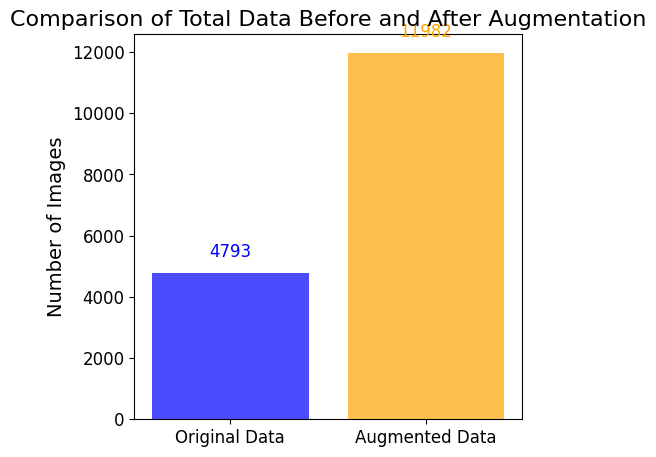

In [10]:
# Calculate total data counts
total_original_data = sum(len(os.listdir(os.path.join(TRAIN_PATH, class_name))) for class_name in class_names)
total_augmented_data = int(total_original_data * 2.5)

# Visualize data counts
plt.figure(figsize=(5, 5))

# Bar plot
plt.bar(['Original Data', 'Augmented Data'], [total_original_data, total_augmented_data], color=['blue', 'orange'], alpha=0.7)

# Add data labels
plt.text(0, total_original_data + 500, str(total_original_data), ha='center', fontsize=12, color='blue')
plt.text(1, total_augmented_data + 500, str(total_augmented_data), ha='center', fontsize=12, color='orange')

# Titles and labels
plt.title('Comparison of Total Data Before and After Augmentation', fontsize=16)
plt.ylabel('Number of Images', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


In [11]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Using sparse_categorical_crossentropy since the labels are integers
              metrics=['accuracy'])

In [13]:
# Early stopping and ReduceLROnPlateau callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [14]:
for images, labels in train_ds.take(1):
    print(images.shape)
    print(labels.shape)
    print(labels)


(32, 224, 224, 3)
(32,)
tf.Tensor(
[15 20 20  6 24  4  6 24 16  4 21  2 27 19 11 21  0  9 27  1 26 29 13 21
  1  3 18 28  4  5  7 29], shape=(32,), dtype=int32)


In [ ]:
# Train the model using train_ds with callbacks
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2956s 20s/step - accuracy: 0.3989 - loss: 5.3145 - val_accuracy: 0.9267 - val_loss: 0.2889 - learning_rate: 0.0010
Epoch 2/100
150/150 ━━━━━━━━━━━━━━━━━━━━ 2862s 19s/step - accuracy: 0.8002 - loss: 0.6682 - val_accuracy: 0.9533 - val_loss: 0.1681 - learning_rate: 0.0010
Epoch 3/100
 28/150 ━━━━━━━━━━━━━━━━━━━━ 38:09 19s/step - accuracy: 0.8399 - loss: 0.5501

In [ ]:
# Plot training results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Evaluate model on validation dataset
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Evaluate model on test dataset
test_loss, test_accuracy = model.evaluate(test_ds)

print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Predict on test dataset
y_pred = []
y_true = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# Classification report
print("\nClassification Report (Test Set):")
print(classification_report(y_true, y_pred, target_names=class_names))

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Save the trained model as an HDF5 file
MODEL_SAVE_PATH = "/content/drive/MyDrive/Colab Notebooks/SEMESTER 7/archive/VGG16_model.h5"
model.save(MODEL_SAVE_PATH)

print(f"Model has been saved to {MODEL_SAVE_PATH}")

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

def upload_and_predict(model, class_names):
    # Upload an image file
    uploaded = files.upload()

    for fn in uploaded.keys():
        # Prepare the image
        path = fn
        img = image.load_img(path, target_size=IMG_SIZE)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # Create a batch

        # Make prediction
        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        # Print the result
        print(
            "This image most likely belongs to {} with a {:.2f} percent confidence."
            .format(class_names[np.argmax(score)], 100 * np.max(score))
        )

        # Display the image
        plt.imshow(img)
        plt.axis('off')
        plt.title("Uploaded Image: {}".format(fn))
        plt.show()

        # Display the prediction probabilities
        plt.figure(figsize=(30, 5))
        plt.bar(class_names, 100 * score)
        plt.title('Prediction Probabilities')
        plt.xlabel('Class')
        plt.ylabel('Probability (%)')
        plt.ylim([0, 100])
        plt.show()

# Assuming 'model' and 'class_names' are already defined
upload_and_predict(model, class_names)